### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
!pip install yfinance --quiet

     |████████████████████████████████| 6.4 MB 6.6 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yf
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
stock = yf.Ticker("ITC.BO")
hist = stock.history(period="10Y")
df = hist[['Close']]

In [4]:
df.head()

,Close
Date,
2012-03-29,116.167740
2012-03-30,117.305359
2012-04-02,117.020958
2012-04-03,117.331207
2012-04-04,117.460510


In [5]:
df.tail()

,Close
Date,
2022-03-23,251.949997
2022-03-24,254.850006
2022-03-25,253.300003
2022-03-28,257.200012
2022-03-29,254.649994


In [6]:
df1 = df.reset_index()['Close']

In [7]:
df1

0       116.167740
1       117.305359
2       117.020958
3       117.331207
4       117.460510
           ...    
2459    251.949997
2460    254.850006
2461    253.300003
2462    257.200012
2463    254.649994
Name: Close, Length: 2464, dtype: float64

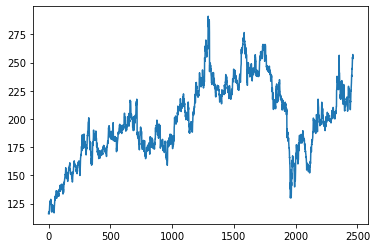

In [8]:
plt.plot(df1)

In [9]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df1

array([[0.00176998],
       [0.00825979],
       [0.00663736],
       ...,
       [0.78407267],
       [0.80632117],
       [0.79177401]])

In [12]:
##splitting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(1601, 863)

In [14]:
train_data

array([[0.00176998],
       [0.00825979],
       [0.00663736],
       ...,
       [0.82774264],
       [0.78793592],
       [0.78917216]])

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
X_train.shape, y_train.shape

((1500, 100), (1500,))

In [18]:
X_test.shape, ytest.shape

((762, 100), (762,))

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train, y_train, validation_data = (X_test,ytest), 
          epochs=10, batch_size=64, verbose=1)

Epoch 1/10
24/24 [==============================] - 14s 302ms/step - loss: 0.0442 - val_loss: 0.0079
Epoch 2/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 4/10
24/24 [==============================] - 9s 354ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 5s 201ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 5s 204ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 5s 205ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0017 - val_loss: 0.00

In [25]:
import tensorflow as tf

In [26]:
### Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [27]:
##Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

197.30725273419537

In [29]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

205.98931749878446

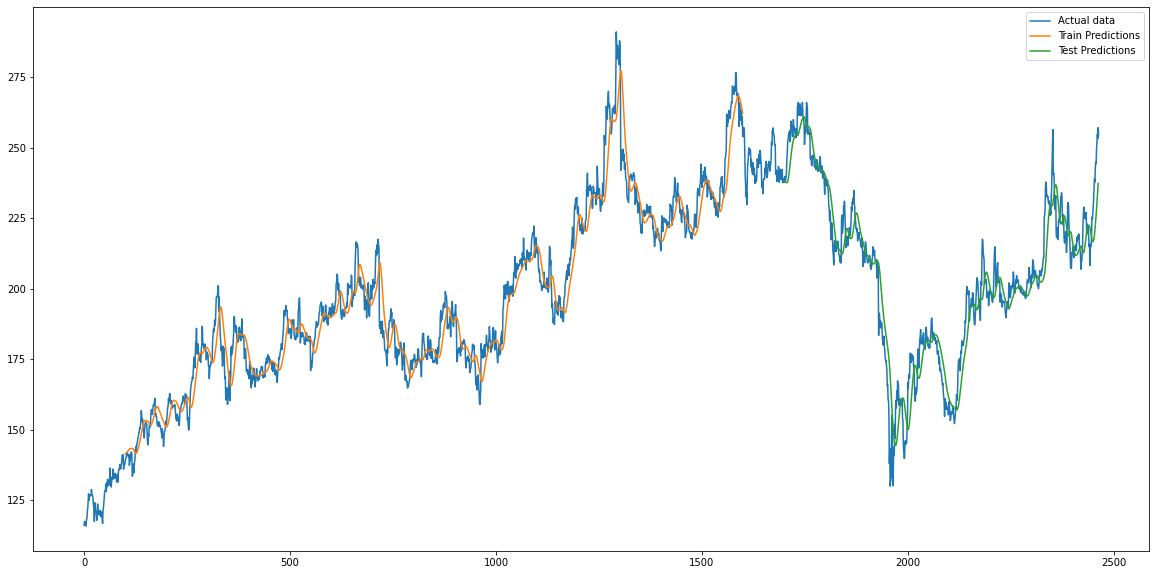

In [30]:
### Plotting 
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize = (20,10))
plt.plot(scaler.inverse_transform(df1), label = 'Actual data' )
plt.plot(trainPredictPlot, label = 'Train Predictions')
plt.plot(testPredictPlot, label = 'Test Predictions')
plt.legend()
plt.show()

In [31]:
len(test_data)

863

In [32]:
x_input = test_data[763:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.5796867664225701,
 0.6022689224159262,
 0.6198327151307382,
 0.6148145259467731,
 0.6262449666537068,
 0.6212266904224523,
 0.6387905701845537,
 0.6663909153618749,
 0.652451336539314,
 0.6744758675970687,
 0.663045426890135,
 0.6268025045420188,
 0.6304268925288486,
 0.6097962497155186,
 0.628754104769334,
 0.5877717186577639,
 0.5735533273674024,
 0.5729957894790904,
 0.5766200033713414,
 0.5961353963134689,
 0.5752260280796276,
 0.5540379344252749,
 0.5693714014922605,
 0.5933475327773304,
 0.6510574482948893,
 0.6546816621871406,
 0.6477118727758601,
 0.6120265753633453,
 0.5880505311255645,
 0.5819170920703968,
 0.5545954723135867,
 0.522813288308413,
 0.524207263600127,
 0.5214193130166992,
 0.5506924459535351,
 0.5545954723135867,
 0.5520864212452489,
 0.5654683751322086,
 0.547904495370107,
 0.5434438440744539,
 0.5545954723135867,
 0.5610077238365553,
 0.5665835379561218,
 0.5688138636039485,
 0.558498585720928,
 0.5573834228970148,
 0.5841474177182234,
 0.5760624654830296,

In [35]:
# demonstrate prediction for next 10 days

lst_output=[]
n_steps =100
i=0 
while(i<300): # from 30 to 300 change kiya
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

Streaming output truncated to the last 5000 lines.
 0.57020784 0.56769879 0.5587774  0.54929847 0.51974653 0.53340729
 0.53591643 0.55208642 0.56630481 0.60868109 0.63070562 0.64548155
 0.6446452  0.62289948 0.62819648 0.62178432 0.63349348 0.63460873
 0.59068223 0.6112193  0.60808168 0.60922261 0.60465889 0.58326615
 0.5652962  0.57100093 0.52735977 0.56016197 0.56986    0.56700763
 0.59039706 0.62519587 0.62148783 0.63346772 0.64601819 0.66256188
 0.68652173 0.702495   0.69564934 0.72303206 0.73586771 0.73330051
 0.76410611 0.77637125 0.79291502 0.78407267 0.80632117 0.79177401
 0.71895331 0.72910047 0.73663121 0.74172628 0.74478388 0.74626535
 0.74660641 0.74617296 0.74524951 0.7440421  0.74269098 0.74128485
 0.7398752  0.73848927 0.73713756 0.73582155 0.7345385  0.73328322
 0.73205101 0.73083729 0.72963852 0.72845221]
22 day output [[0.72727615]]
23 day input [0.59334753 0.65105745 0.65468166 0.64771187 0.61202658 0.58805053
 0.58191709 0.55459547 0.52281329 0.52420726 0.52141931 0

In [42]:
day_new=np.arange(1,101)
day_pred=np.arange(101,401) # changed from 131 to 401

In [43]:
len(df1)

2464

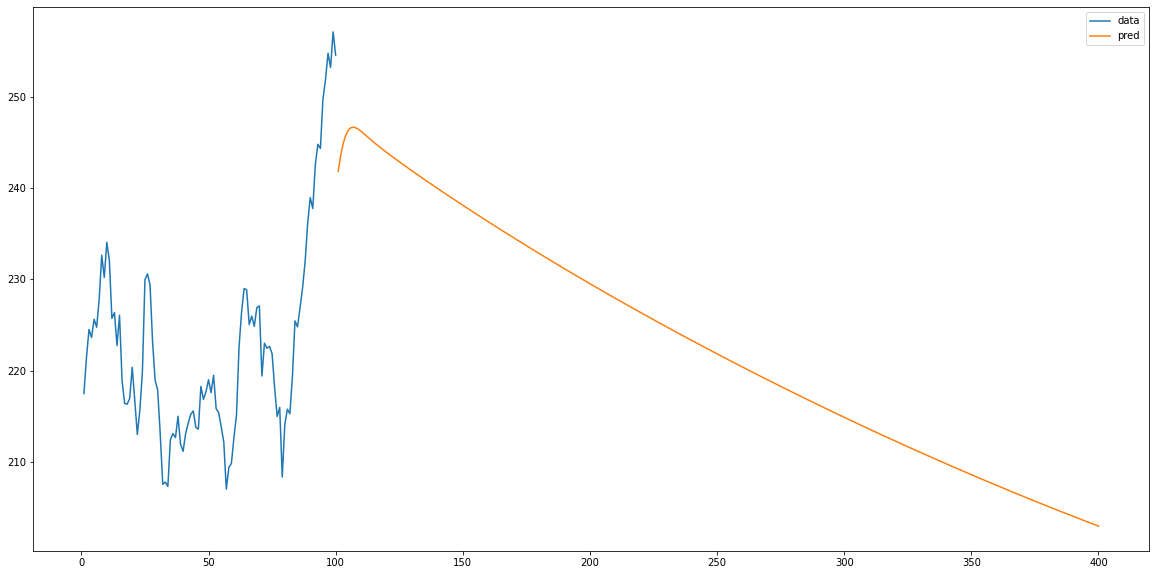

In [44]:
plt.figure(figsize = (20,10))
plt.plot(day_new, scaler.inverse_transform(df1[2364:]), label = 'data')
plt.plot(day_pred, scaler.inverse_transform(lst_output), label = 'pred')
plt.legend()

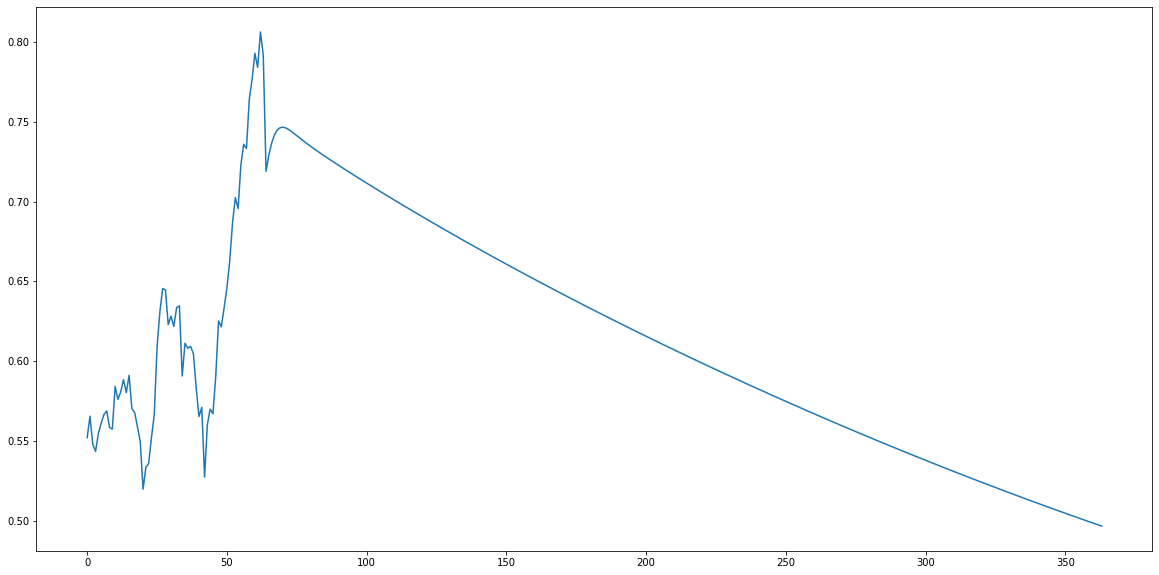

In [45]:
plt.figure(figsize = (20,10))
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2400:])

In [46]:
df3=scaler.inverse_transform(df3).tolist()

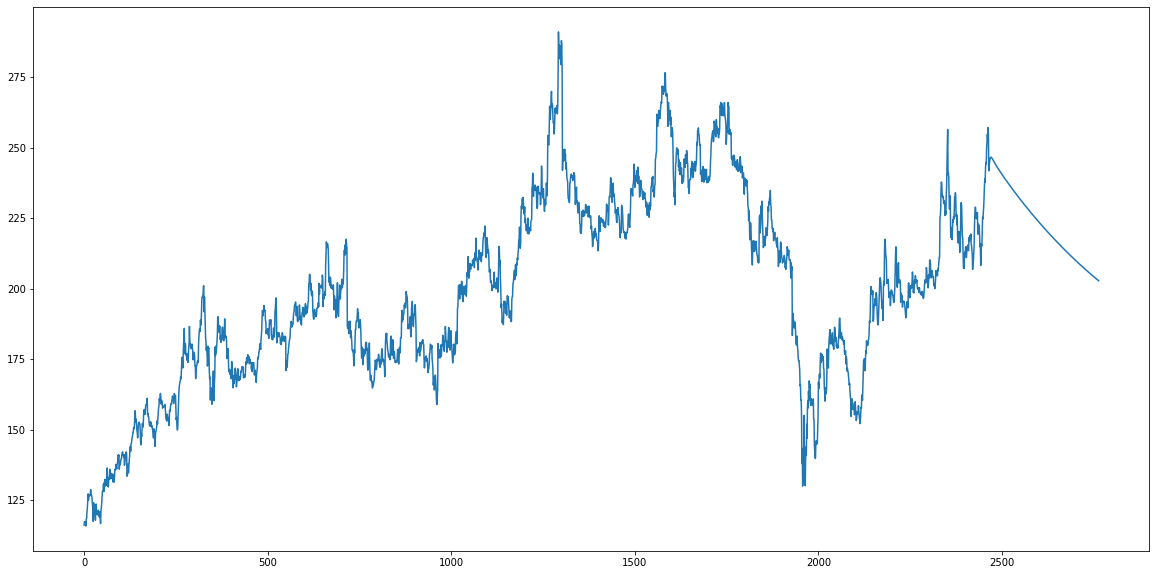

In [47]:
plt.figure(figsize = (20,10))
plt.plot(df3)